# Preprocessing

## Import all necessary Library

In [255]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from numpy import interp
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from numpy import interp
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier

In [199]:
def ROC(y_one_hot, y_one_hot_pred):
    n_classes = 11

    # 计算每一类的ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_one_hot[:, i], y_one_hot_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # micro（方法二）
    fpr["micro"], tpr["micro"], _ = roc_curve(y_one_hot.ravel(), y_one_hot_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # macro（方法一）
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw=2
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('multi-calss ROC')
    plt.legend(loc="lower right")
    plt.show()

## Data process

### File Reading

In [139]:
np.set_printoptions(suppress=True, precision=20, threshold=10, linewidth=40)  # np forbids scientific counting
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # pd forbids scientific counting

In [140]:
path = "data/train_data.csv"

df_all = pd.read_csv(path)  # Read the data according to your own file address

df_all.drop_duplicates(
    inplace=True)  # drop_duplicates are used to perform deduplication, and inplace=True replaces the original data set
df_all.reset_index(drop=True, inplace=True)  # After deleting the data, restore the index

df_all

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.00,31397,7.00,Emergency,Extreme,2,51-60,4911.00,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.00,31397,7.00,Trauma,Extreme,2,51-60,5954.00,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.00,31397,7.00,Trauma,Extreme,2,51-60,4745.00,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,7272.00,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,5558.00,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.00,86499,23.00,Emergency,Moderate,3,41-50,4144.00,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.00,325,8.00,Urgent,Moderate,4,81-90,6699.00,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.00,125235,10.00,Emergency,Minor,3,71-80,4235.00,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.00,91081,8.00,Trauma,Minor,5,11-20,3761.00,11-20


In [141]:
# Look at data types and missing cases as a whole
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [142]:
df_all['Hospital_code'] = df_all['Hospital_code'].astype(object)
df_all['City_Code_Hospital'] = df_all['City_Code_Hospital'].astype(object)
df_all['Bed Grade'] = df_all['Bed Grade'].astype(object)
df_all['City_Code_Patient'] = df_all['City_Code_Patient'].astype(object)
df_all['Hospital_code'] = df_all['Hospital_code'].astype(float)
df_all['Available Extra Rooms in Hospital'] = df_all['Available Extra Rooms in Hospital'].astype(float)
df_all['patientid'] = df_all['patientid'].astype(float)
df_all['Visitors with Patient'] = df_all['Visitors with Patient'].astype(float)

In [143]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  float64
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  object 
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  float64
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  object 
 10  patientid                          318438 non-null  float64
 11  City_Code_Patient                  3139

In [144]:
# Define a function to find missing variables and return a list of missing value rate > specified missing rate (narate)
def filter_col_by_nan(data, narate=0.2):
    '''
    :param data: 查找数据集
    :param narate: 设定变量的缺失值率
    :return: 返回 缺失率>narate的变量名称列表
    '''
    n_samples = data.shape[0]
    list_nan_cols = []
    for col in data.columns:
        if data[col].isna().sum() / n_samples >= (narate):
            list_nan_cols.append(col)
    print(f'Variables with more than {narate * 100}% missing are: {list_nan_cols}')
    return list_nan_cols


list_nullfactor_todrop = filter_col_by_nan(df_all, narate=0.3)
df_select = df_all.drop(list_nullfactor_todrop, axis=1).copy()
df_select

Variables with more than 30.0% missing are: []


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8.00,c,3,Z,3.00,radiotherapy,R,F,2.00,31397.00,7.00,Emergency,Extreme,2.00,51-60,4911.00,0-10
1,2,2.00,c,5,Z,2.00,radiotherapy,S,F,2.00,31397.00,7.00,Trauma,Extreme,2.00,51-60,5954.00,41-50
2,3,10.00,e,1,X,2.00,anesthesia,S,E,2.00,31397.00,7.00,Trauma,Extreme,2.00,51-60,4745.00,31-40
3,4,26.00,b,2,Y,2.00,radiotherapy,R,D,2.00,31397.00,7.00,Trauma,Extreme,2.00,51-60,7272.00,41-50
4,5,26.00,b,2,Y,2.00,radiotherapy,S,D,2.00,31397.00,7.00,Trauma,Extreme,2.00,51-60,5558.00,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6.00,a,6,X,3.00,radiotherapy,Q,F,4.00,86499.00,23.00,Emergency,Moderate,3.00,41-50,4144.00,11-20
318434,318435,24.00,a,1,X,2.00,anesthesia,Q,E,4.00,325.00,8.00,Urgent,Moderate,4.00,81-90,6699.00,31-40
318435,318436,7.00,a,4,X,3.00,gynecology,R,F,4.00,125235.00,10.00,Emergency,Minor,3.00,71-80,4235.00,11-20
318436,318437,11.00,b,2,Y,3.00,anesthesia,Q,D,3.00,91081.00,8.00,Trauma,Minor,5.00,11-20,3761.00,11-20


### Variables Analysis

#### Univariate Analysis

In [ ]:
df_select['Stay'].replace('More than 100 Days', '>100', inplace=True)

for i in ['Stay', 'Department', 'Available Extra Rooms in Hospital', 'Ward_Type', 'Ward_Facility_Code', 'Age',
          'Type of Admission', 'Severity of Illness', 'Bed Grade', 'Hospital_region_code', 'Hospital_type_code',
          'City_Code_Hospital', 'Hospital_code', 'City_Code_Patient', 'Visitors with Patient']:
    count = df_select[i].value_counts()

    plt.figure(figsize=(10, 5))
    sns.barplot(x=count.index.values, y=count.values, data=df_select)
    plt.xlabel(i)
    plt.ylabel('Value')

### Bivariate Analysis

In [ ]:
for i in ['Department', 'Ward_Type', 'Ward_Facility_Code', 'Age', 'Type of Admission', 'Severity of Illness',
          'Bed Grade', 'Hospital_region_code', 'Hospital_type_code']:
    plt.figure(figsize=(10, 5))

    sns.countplot(x='Stay', hue=i, data=df_select)

#### Numerical Features

C:\Users\AORUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Admission_Deposit', ylabel='Density'>

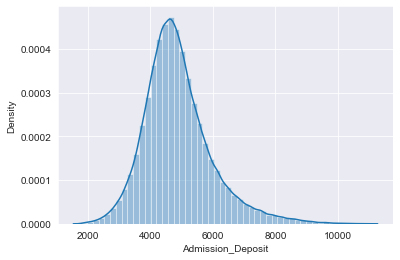

In [147]:
sns.distplot(df_select['Admission_Deposit'])

### Missing values

In [148]:
df_select.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [149]:
def impute_missing_values(data, columns):
    for column in columns:
        data[column] = data[column].fillna(data[column].value_counts().index[0])
        print(data[column].value_counts().index[0])

In [150]:
impute_columns = ['Bed Grade', 'City_Code_Patient']
impute_missing_values(df_select, impute_columns)

2.0
8.0


In [151]:
df_select.isnull().sum()

case_id                              0
Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
Available Extra Rooms in Hospital    0
Department                           0
Ward_Type                            0
Ward_Facility_Code                   0
Bed Grade                            0
patientid                            0
City_Code_Patient                    0
Type of Admission                    0
Severity of Illness                  0
Visitors with Patient                0
Age                                  0
Admission_Deposit                    0
Stay                                 0
dtype: int64

### Encoding

In [152]:
admission_encode = {'Trauma': 1, 'Urgent': 2, 'Emergency': 3}
severity_encode = {'Minor': 1, 'Moderate': 2, 'Extreme': 3}

df_select['Type of Admission'] = df_select['Type of Admission'].map(admission_encode)
df_select['Severity of Illness'] = df_select['Severity of Illness'].map(severity_encode)

df_select['Age'] = df_select['Age'].replace(
    {'0-10': 1, '11-20': 2, '21-30': 3, '31-40': 4, '41-50': 5, '51-60': 6, '61-70': 7,
     '71-80': 8, '81-90': 9, '91-100': 10})

df_select['Stay'] = df_select['Stay'].replace(
    {'0-10': 1, '11-20': 2, '21-30': 3, '31-40': 4, '41-50': 5, '51-60': 6, '61-70': 7,
     '71-80': 8, '81-90': 9, '91-100': 10, '>100': 11})

In [153]:
sequence_columns = ['Available Extra Rooms in Hospital', 'Bed Grade', 'Visitors with Patient', 'Admission_Deposit',
                    'Type of Admission', 'Severity of Illness', 'Age', 'Stay']
onehot_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code']
other_columns = ['Hospital_code', 'City_Code_Hospital', 'patientid', 'City_Code_Patient']

In [154]:
def onehot_encode(data, columns):
    for column in columns:
        dummies = pd.get_dummies(data[column])
        data = pd.concat([data, dummies], axis=1)
        data.drop(column, axis=1, inplace=True)

    return data

In [155]:
df_select

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8.00,c,3,Z,3.00,radiotherapy,R,F,2.00,31397.00,7.00,3,3,2.00,6,4911.00,1
1,2,2.00,c,5,Z,2.00,radiotherapy,S,F,2.00,31397.00,7.00,1,3,2.00,6,5954.00,5
2,3,10.00,e,1,X,2.00,anesthesia,S,E,2.00,31397.00,7.00,1,3,2.00,6,4745.00,4
3,4,26.00,b,2,Y,2.00,radiotherapy,R,D,2.00,31397.00,7.00,1,3,2.00,6,7272.00,5
4,5,26.00,b,2,Y,2.00,radiotherapy,S,D,2.00,31397.00,7.00,1,3,2.00,6,5558.00,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6.00,a,6,X,3.00,radiotherapy,Q,F,4.00,86499.00,23.00,3,2,3.00,5,4144.00,2
318434,318435,24.00,a,1,X,2.00,anesthesia,Q,E,4.00,325.00,8.00,2,2,4.00,9,6699.00,4
318435,318436,7.00,a,4,X,3.00,gynecology,R,F,4.00,125235.00,10.00,3,1,3.00,8,4235.00,2
318436,318437,11.00,b,2,Y,3.00,anesthesia,Q,D,3.00,91081.00,8.00,1,1,5.00,2,3761.00,2


In [156]:
data = onehot_encode(df_select, onehot_columns)
data

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,...,R,S,T,U,A,B,C,D,E,F
0,1,8.00,3,3.00,2.00,31397.00,7.00,3,3,2.00,...,1,0,0,0,0,0,0,0,0,1
1,2,2.00,5,2.00,2.00,31397.00,7.00,1,3,2.00,...,0,1,0,0,0,0,0,0,0,1
2,3,10.00,1,2.00,2.00,31397.00,7.00,1,3,2.00,...,0,1,0,0,0,0,0,0,1,0
3,4,26.00,2,2.00,2.00,31397.00,7.00,1,3,2.00,...,1,0,0,0,0,0,0,1,0,0
4,5,26.00,2,2.00,2.00,31397.00,7.00,1,3,2.00,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6.00,6,3.00,4.00,86499.00,23.00,3,2,3.00,...,0,0,0,0,0,0,0,0,0,1
318434,318435,24.00,1,2.00,4.00,325.00,8.00,2,2,4.00,...,0,0,0,0,0,0,0,0,1,0
318435,318436,7.00,4,3.00,4.00,125235.00,10.00,3,1,3.00,...,1,0,0,0,0,0,0,0,0,1
318436,318437,11.00,2,3.00,3.00,91081.00,8.00,1,1,5.00,...,0,0,0,0,0,0,0,1,0,0


### Scaling

In [157]:
data.set_index('case_id', inplace=True)

y = data['Stay']
X = data.drop(['Stay'], axis=1)

In [158]:
y

case_id
1         1
2         5
3         4
4         5
5         5
         ..
318434    2
318435    4
318436    2
318437    2
318438    1
Name: Stay, Length: 318438, dtype: int64

In [159]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

In [160]:
X

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,...,R,S,T,U,A,B,C,D,E,F
case_id,,,,,,,,,,,,,,,,,,,,,
1,0.23,0.17,0.12,0.33,0.24,0.16,1.00,1.00,0.06,0.56,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,0.03,0.33,0.08,0.33,0.24,0.16,0.00,1.00,0.06,0.56,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3,0.29,0.00,0.08,0.33,0.24,0.16,0.00,1.00,0.06,0.56,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,0.81,0.08,0.08,0.33,0.24,0.16,0.00,1.00,0.06,0.56,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
5,0.81,0.08,0.08,0.33,0.24,0.16,0.00,1.00,0.06,0.56,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318434,0.16,0.42,0.12,1.00,0.66,0.59,1.00,0.50,0.09,0.44,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
318435,0.74,0.00,0.08,1.00,0.00,0.19,0.50,0.50,0.12,0.89,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
318436,0.19,0.25,0.12,1.00,0.95,0.24,1.00,0.00,0.09,0.78,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


### Dataset Splitting

In [161]:
X_all = X
Y_all = y
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, random_state=10, test_size=0.2)

In [162]:
print(Xtrain.shape)
print(Xtest.shape)
print(Ytrain.shape)
print(Ytest.shape)
print(X_all.shape)
print(Y_all.shape)

(254750, 38)
(63688, 38)
(254750,)
(63688,)
(318438, 38)
(318438,)


## Feature Selection

In [ ]:
RFC_ = RandomForestClassifier()

In [ ]:
# Importance of feature
# c = RFC_.fit(Xtrain, Ytrain).feature_importances_
# print("Importance: ")
# c

In [ ]:
# Recursive feature elimination
selector1 = RFE(RFC_, n_features_to_select=0.5, step=1).fit(Xtrain, Ytrain)

In [ ]:
selector1.support_.sum()
print(selector1.ranking_)
print(selector1.n_features_)
X_wrapper1 = selector1.transform(Xtrain)

In [ ]:
score = cross_val_score(RFC_, X_wrapper1, Ytrain).mean()
score

In [ ]:
# The number of features selected
selector1.n_features_

In [ ]:
# Feature exclusion sort
selector1.ranking_

In [ ]:
support_cat_list = selector1.support_

In [163]:
support_cat_list = [True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    True,
                    True,
                    True,
                    False,
                    False,
                    True,
                    True,
                    True,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    True]
support_cat_list

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True]

In [164]:
# 4.递归特征消除法和曲线图选取最优特征数量
score = []  # 建立列表
for i in range(12, 22, 1):
    X_wrapper = RFE(RFC_, n_features_to_select=i, step=1).fit_transform(Xtrain, Ytrain)
    once = cross_val_score(RFC_, X_wrapper, Ytrain, cv=3).mean()  # 交叉验证
    score.append(once)  # 交叉验证结果保存到列表
print(max(score), (score.index(max(score)) * 1) + 1)  # 输出最优分类结果和对应的特征数量
print(score)
plt.figure(figsize=[20, 5])
plt.plot(range(12, 22, 1), score)
plt.xticks(range(12, 22, 1))
plt.show()

NameError: name 'RFC_' is not defined

In [ ]:
# RFE.ranking_

In [165]:
columns_list = list(Xtrain.columns)

In [166]:
list_factor_todrop = []
for i in range(38):
    if support_cat_list[i] is False:
        list_factor_todrop.append(columns_list[i])

list_factor_todrop  #需要抛弃的变量

['b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'X',
 'Y',
 'Z',
 'TB & Chest disease',
 'surgery',
 'P',
 'T',
 'U',
 'A',
 'B',
 'C',
 'D',
 'E']

In [167]:
Xtrain.drop(list_factor_todrop, axis=1, inplace=True)
Xtest.drop(list_factor_todrop, axis=1, inplace=True)
X_all.drop(list_factor_todrop, axis=1, inplace=True)

In [168]:

Xtrain_remove_other = Xtrain.drop(other_columns, axis=1)
Xtest_remove_other = Xtest.drop(other_columns, axis=1)


In [169]:
Xtrain

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,a,anesthesia,gynecology,radiotherapy,Q,R,S,F
case_id,,,,,,,,,,,,,,,,,,,
54023,0.06,0.17,0.17,0.33,0.63,0.19,0.50,0.50,0.06,0.22,0.31,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
12007,0.71,0.42,0.08,1.00,0.26,0.19,0.00,0.00,0.06,0.44,0.49,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
1873,0.77,0.00,0.17,0.67,0.86,0.00,1.00,0.50,0.19,0.22,0.19,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
120504,0.00,0.75,0.17,0.00,0.34,0.19,0.00,1.00,0.12,0.67,0.43,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
32848,0.77,0.00,0.17,0.33,0.69,0.03,0.00,0.50,0.12,0.56,0.27,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299742,0.58,0.50,0.12,0.33,0.93,0.19,1.00,0.00,0.12,0.33,0.34,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
9373,0.77,0.00,0.17,0.67,0.40,0.19,0.00,0.50,0.12,0.56,0.38,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
105596,0.58,0.50,0.08,0.33,0.40,0.19,1.00,0.50,0.12,0.44,0.26,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


In [170]:
Xtrain_remove_other

,Available Extra Rooms in Hospital,Bed Grade,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,a,anesthesia,gynecology,radiotherapy,Q,R,S,F
case_id,,,,,,,,,,,,,,,
54023,0.17,0.33,0.50,0.50,0.06,0.22,0.31,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
12007,0.08,1.00,0.00,0.00,0.06,0.44,0.49,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
1873,0.17,0.67,1.00,0.50,0.19,0.22,0.19,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
120504,0.17,0.00,0.00,1.00,0.12,0.67,0.43,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
32848,0.17,0.33,0.00,0.50,0.12,0.56,0.27,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299742,0.12,0.33,1.00,0.00,0.12,0.33,0.34,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
9373,0.17,0.67,0.00,0.50,0.12,0.56,0.38,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
105596,0.08,0.33,1.00,0.50,0.12,0.44,0.26,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


In [171]:
Ytrain

case_id
54023     4
12007     3
1873      6
120504    3
32848     3
         ..
299742    2
9373      3
105596    4
93554     2
236670    2
Name: Stay, Length: 254750, dtype: int64

# Model Training & Evaluation

## Information Based Learning

### Decision Tree

In [172]:
decision_tree_classification = DecisionTreeClassifier(criterion='entropy', random_state=10)

decision_tree = decision_tree_classification.fit(Xtrain, Ytrain)
y_pred_DT = decision_tree.predict(Xtest)

accuracy_score(Ytest, y_pred_DT) * 100

29.437256626052005

In [173]:
y_one_hot = label_binarize(Ytest, classes=[1,2,3,4,5,6,7,8,9,10,11])
y_one_hot_pred_DT = label_binarize(y_pred_DT, classes=[1,2,3,4,5,6,7,8,9,10,11])
y_one_hot

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [178]:
accuracy_score_array = np.ndarray(shape=(1,11), dtype=float)
for i in range(11):
    accuracy_score_array[0,i] = accuracy_score(y_one_hot[:,i], y_one_hot_pred_DT[:,i])
accuracy_score_array.mean() *100

87.17041029564581

In [175]:
print(classification_report(Ytest, y_pred_DT))

              precision    recall  f1-score   support

           1       0.19      0.19      0.19      4805
           2       0.34      0.34      0.34     15569
           3       0.38      0.37      0.38     17460
           4       0.24      0.24      0.24     11083
           5       0.06      0.07      0.07      2321
           6       0.31      0.31      0.31      6944
           7       0.04      0.05      0.04       545
           8       0.16      0.17      0.16      2073
           9       0.22      0.21      0.22      1010
          10       0.11      0.12      0.12       562
          11       0.36      0.37      0.37      1316

    accuracy                           0.29     63688
   macro avg       0.22      0.22      0.22     63688
weighted avg       0.30      0.29      0.30     63688



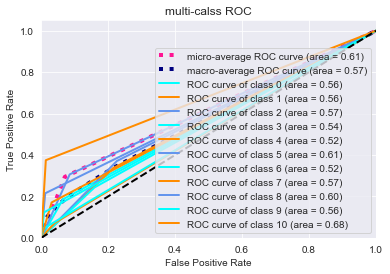

In [177]:
ROC(y_one_hot, y_one_hot_pred_DT)

## Decision Tree with HyperParameter adjustment

In [ ]:
paramGrid = dict(
    max_depth=range(15),
    criterion=["gini", "entropy"])
dtModel = DecisionTreeClassifier(random_state=10)
grid = GridSearchCV(dtModel, paramGrid, cv=10, return_train_score=True)
grid.fit(Xtrain, Ytrain)
print(grid.best_params_)

In [ ]:
print(grid.best_params_)

In [179]:
decision_tree_classification = DecisionTreeClassifier(criterion='gini', random_state=10, max_depth=10)

decision_tree = decision_tree_classification.fit(Xtrain, Ytrain)
y_pred_DT = decision_tree.predict(Xtest)
accuracy_score(Ytest, y_pred_DT) * 100

40.915086044466776

In [180]:
print(classification_report(Ytest, y_pred_DT))

              precision    recall  f1-score   support

           1       0.37      0.14      0.21      4805
           2       0.42      0.45      0.43     15569
           3       0.41      0.68      0.51     17460
           4       0.41      0.23      0.29     11083
           5       0.10      0.00      0.00      2321
           6       0.39      0.47      0.43      6944
           7       0.00      0.00      0.00       545
           8       0.26      0.03      0.05      2073
           9       0.39      0.15      0.22      1010
          10       0.35      0.02      0.03       562
          11       0.50      0.39      0.44      1316

    accuracy                           0.41     63688
   macro avg       0.33      0.23      0.24     63688
weighted avg       0.39      0.41      0.37     63688



In [181]:
y_one_hot = label_binarize(Ytest, classes=[1,2,3,4,5,6,7,8,9,10,11])
y_one_hot_pred_DT = label_binarize(y_pred_DT, classes=[1,2,3,4,5,6,7,8,9,10,11])
y_one_hot

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [184]:
accuracy_score_array = np.ndarray(shape=(1,11), dtype=float)
for i in range(11):
    accuracy_score_array[0,i] = accuracy_score(y_one_hot[:,i], y_one_hot_pred_DT[:,i])
accuracy_score_array.mean() * 100

89.25728837172123

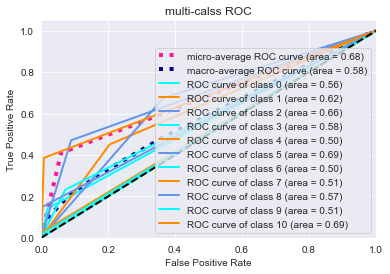

In [185]:
ROC(y_one_hot, y_one_hot_pred_DT)

## Random Forest

In [186]:
rf_classification = RandomForestClassifier(random_state=10)

rf_model = rf_classification.fit(Xtrain, Ytrain)
y_pred_RF = rf_model.predict(Xtest)
accuracy_score(Ytest, y_pred_RF) * 100

40.31057656073357

In [187]:
print(classification_report(Ytest, y_pred_RF))

              precision    recall  f1-score   support

           1       0.34      0.17      0.23      4805
           2       0.40      0.47      0.43     15569
           3       0.42      0.58      0.49     17460
           4       0.37      0.26      0.31     11083
           5       0.12      0.01      0.02      2321
           6       0.40      0.48      0.44      6944
           7       0.21      0.01      0.02       545
           8       0.38      0.08      0.13      2073
           9       0.45      0.22      0.29      1010
          10       0.46      0.06      0.10       562
          11       0.57      0.48      0.52      1316

    accuracy                           0.40     63688
   macro avg       0.37      0.26      0.27     63688
weighted avg       0.39      0.40      0.38     63688



In [188]:
y_one_hot = label_binarize(Ytest, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y_one_hot_pred_RF = label_binarize(y_pred_RF, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y_one_hot

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [189]:
accuracy_score_array = np.ndarray(shape=(1, 11), dtype=float)
for i in range(11):
    accuracy_score_array[0, i] = accuracy_score(y_one_hot[:, i], y_one_hot_pred_RF[:, i])
accuracy_score_array.mean()

0.89147377556497

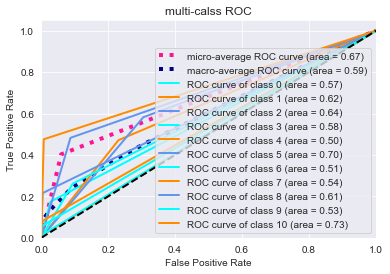

In [190]:
ROC(y_one_hot, y_one_hot_pred_RF)

## Random Forest with HyperParameter adjustment

In [ ]:
paramGrid = dict(
    n_estimators=np.linspace(10, 100, 10).astype(int),
    max_depth=np.arange(4, 11))
rfModel = RandomForestClassifier(random_state=10)
grid = GridSearchCV(rfModel, paramGrid, cv=10, return_train_score=True)
grid.fit(Xtrain, Ytrain)
print(grid.best_params_)

In [191]:
rf_classification = RandomForestClassifier(random_state=10, max_depth=10, n_estimators=100)

rf_model = rf_classification.fit(Xtrain, Ytrain)
y_pred_RF = rf_model.predict(Xtest)
accuracy_score(Ytest, y_pred_RF) * 100

41.46621027509107

In [192]:
print(classification_report(Ytest, y_pred_RF))

              precision    recall  f1-score   support

           1       0.47      0.09      0.15      4805
           2       0.41      0.53      0.46     15569
           3       0.42      0.63      0.50     17460
           4       0.43      0.23      0.30     11083
           5       0.00      0.00      0.00      2321
           6       0.39      0.52      0.44      6944
           7       0.00      0.00      0.00       545
           8       0.00      0.00      0.00      2073
           9       0.75      0.01      0.01      1010
          10       0.00      0.00      0.00       562
          11       0.54      0.38      0.45      1316

    accuracy                           0.41     63688
   macro avg       0.31      0.22      0.21     63688
weighted avg       0.39      0.41      0.37     63688



C:\Users\AORUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AORUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AORUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [193]:
y_one_hot = label_binarize(Ytest, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y_one_hot_pred_RF = label_binarize(y_pred_RF, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y_one_hot

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [194]:
accuracy_score_array = np.ndarray(shape=(1, 11), dtype=float)
for i in range(11):
    accuracy_score_array[0, i] = accuracy_score(y_one_hot[:, i], y_one_hot_pred_RF[:, i])
accuracy_score_array.mean() * 100

89.35749277728928

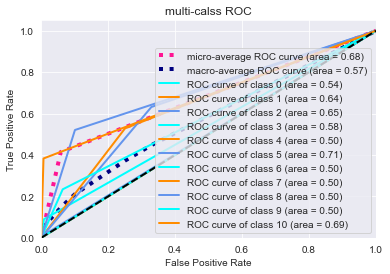

In [195]:
ROC(y_one_hot, y_one_hot_pred_RF)

## Similarity Based Learning

### KNN with HyperParameter adjustment

In [ ]:
paramGrid = dict(
    n_neighbors=[10, 50, 300, 500, 1000],
    weights=["uniform", "distance"])
knnModel = KNeighborsClassifier()
grid = GridSearchCV(knnModel, paramGrid, cv=3, return_train_score=True)
grid.fit(Xtrain_remove_other, Ytrain)
print(grid.best_params_)

In [200]:
knn = KNeighborsClassifier(n_neighbors=300, weights='distance')
knn.fit(Xtrain_remove_other, Ytrain)
y_pred_KNN = knn.predict(Xtest_remove_other)
accuracy_score(Ytest, y_pred_KNN) * 100

32.23527195075995

In [201]:
print(classification_report(Ytest, y_pred_KNN))

              precision    recall  f1-score   support

           1       0.22      0.04      0.06      4805
           2       0.31      0.50      0.38     15569
           3       0.35      0.56      0.43     17460
           4       0.26      0.12      0.16     11083
           5       0.04      0.00      0.01      2321
           6       0.31      0.20      0.25      6944
           7       0.03      0.00      0.00       545
           8       0.13      0.01      0.02      2073
           9       0.17      0.00      0.01      1010
          10       0.03      0.00      0.00       562
          11       0.61      0.04      0.07      1316

    accuracy                           0.32     63688
   macro avg       0.22      0.13      0.13     63688
weighted avg       0.29      0.32      0.27     63688



In [202]:
y_one_hot = label_binarize(Ytest, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y_one_hot_pred_KNN = label_binarize(y_pred_KNN, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y_one_hot

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [203]:
accuracy_score_array = np.ndarray(shape=(1, 11), dtype=float)
for i in range(11):
    accuracy_score_array[0, i] = accuracy_score(y_one_hot[:, i], y_one_hot_pred_KNN[:, i])
accuracy_score_array.mean() * 100

87.67914035468361

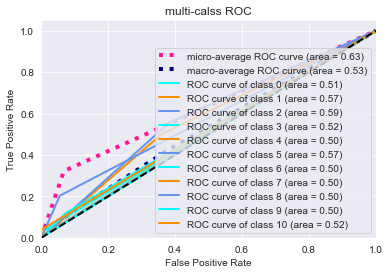

In [204]:
ROC(y_one_hot, y_one_hot_pred_KNN)

### kd-Tree

In [205]:
# kd-Tree

## Probability Based Learning

### Naive Bayes

#### Gaussian NB

In [206]:
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()
NB.fit(Xtrain_remove_other, Ytrain)

y_pred_NB = NB.predict(Xtest_remove_other)
accuracy_score(Ytest, y_pred_NB) * 100

34.9783318678558

In [207]:
print(classification_report(Ytest, y_pred_NB))

              precision    recall  f1-score   support

           1       0.27      0.14      0.19      4805
           2       0.35      0.36      0.35     15569
           3       0.39      0.62      0.48     17460
           4       0.29      0.12      0.16     11083
           5       0.06      0.00      0.01      2321
           6       0.31      0.48      0.38      6944
           7       0.00      0.00      0.00       545
           8       0.13      0.02      0.03      2073
           9       0.03      0.00      0.01      1010
          10       0.17      0.00      0.00       562
          11       0.33      0.36      0.34      1316

    accuracy                           0.35     63688
   macro avg       0.21      0.19      0.18     63688
weighted avg       0.31      0.35      0.31     63688



In [211]:
y_one_hot = label_binarize(Ytest, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y_one_hot_pred_NB = label_binarize(y_pred_NB, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y_one_hot

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [212]:
accuracy_score_array = np.ndarray(shape=(1, 11), dtype=float)
for i in range(11):
    accuracy_score_array[0, i] = accuracy_score(y_one_hot[:, i], y_one_hot_pred_NB[:, i])
accuracy_score_array.mean() * 100

88.17787852142833

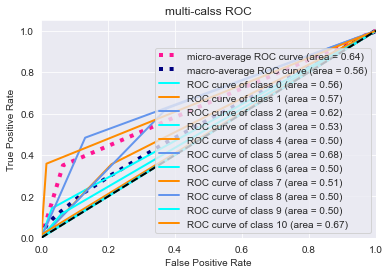

In [214]:
ROC(y_one_hot, y_one_hot_pred_NB)

#### Categorical NB & Multinomial NB

In [215]:
Xtest_remove_other

,Available Extra Rooms in Hospital,Bed Grade,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,a,anesthesia,gynecology,radiotherapy,Q,R,S,F
case_id,,,,,,,,,,,,,,,
304487,0.08,0.33,1.00,0.00,0.06,0.56,0.24,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00
315373,0.08,1.00,0.00,0.00,0.19,0.33,0.48,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
158272,0.12,0.33,0.50,0.00,0.09,0.67,0.47,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
3609,0.17,0.33,0.00,0.50,0.12,0.22,0.38,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00
13537,0.08,0.67,1.00,0.50,0.06,0.89,0.47,1.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294067,0.08,0.33,1.00,0.00,0.06,0.56,0.28,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
77724,0.08,0.33,0.00,0.50,0.12,0.67,0.30,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
187546,0.17,1.00,1.00,0.00,0.06,0.33,0.32,1.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00


In [216]:
from sklearn.preprocessing import KBinsDiscretizer

Xtrain_num = Xtrain_remove_other[['Available Extra Rooms in Hospital', 'Visitors with Patient', 'Admission_Deposit']]
Xtrain_cat = Xtrain_remove_other.drop(
    ['Available Extra Rooms in Hospital', 'Visitors with Patient', 'Admission_Deposit'], axis=1)
Xtest_num = Xtest_remove_other[['Available Extra Rooms in Hospital', 'Visitors with Patient', 'Admission_Deposit']]
Xtest_cat = Xtest_remove_other.drop(['Available Extra Rooms in Hospital', 'Visitors with Patient', 'Admission_Deposit'],
                                    axis=1)
kbs = KBinsDiscretizer(n_bins=5, encode='onehot').fit(Xtrain_num)

Xtrain_cat

C:\Users\AORUS\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\AORUS\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


,Bed Grade,Type of Admission,Severity of Illness,Age,a,anesthesia,gynecology,radiotherapy,Q,R,S,F
case_id,,,,,,,,,,,,
54023,0.33,0.50,0.50,0.22,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
12007,1.00,0.00,0.00,0.44,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
1873,0.67,1.00,0.50,0.22,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
120504,0.00,0.00,1.00,0.67,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
32848,0.33,0.00,0.50,0.56,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
299742,0.33,1.00,0.00,0.33,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
9373,0.67,0.00,0.50,0.56,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
105596,0.33,1.00,0.50,0.44,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


In [217]:
Xtrain_num

,Available Extra Rooms in Hospital,Visitors with Patient,Admission_Deposit
case_id,,,
54023,0.17,0.06,0.31
12007,0.08,0.06,0.49
1873,0.17,0.19,0.19
120504,0.17,0.12,0.43
32848,0.17,0.12,0.27
...,...,...,...
299742,0.12,0.12,0.34
9373,0.17,0.12,0.38
105596,0.08,0.12,0.26


In [218]:
Xtrain_num_1 = pd.cut(Xtrain_num['Available Extra Rooms in Hospital'], 5, labels=False)
Xtrain_num_2 = pd.cut(Xtrain_num['Visitors with Patient'], 5, labels=False)
Xtrain_num_3 = pd.cut(Xtrain_num['Admission_Deposit'], 5, labels=False)

Xtest_num_1 = pd.cut(Xtest_num['Available Extra Rooms in Hospital'], 5, labels=False)
Xtest_num_2 = pd.cut(Xtest_num['Visitors with Patient'], 5, labels=False)
Xtest_num_3 = pd.cut(Xtest_num['Admission_Deposit'], 5, labels=False)

Xtrain_NB = pd.merge(Xtrain_num_1, Xtrain_num_2, left_index=True, right_index=True)
Xtrain_NB = pd.merge(Xtrain_NB, Xtrain_num_3, left_index=True, right_index=True)

Xtest_NB = pd.merge(Xtest_num_1, Xtest_num_2, left_index=True, right_index=True)
Xtest_NB = pd.merge(Xtest_NB, Xtest_num_3, left_index=True, right_index=True)

In [219]:
Xtrain_NB

,Available Extra Rooms in Hospital,Visitors with Patient,Admission_Deposit
case_id,,,
54023,0,0,1
12007,0,0,2
1873,0,0,0
120504,0,0,2
32848,0,0,1
...,...,...,...
299742,0,0,1
9373,0,0,1
105596,0,0,1


In [220]:
Xtest_NB

,Available Extra Rooms in Hospital,Visitors with Patient,Admission_Deposit
case_id,,,
304487,0,0,1
315373,0,0,2
158272,1,0,2
3609,1,0,1
13537,0,0,2
...,...,...,...
294067,0,0,1
77724,0,0,1
187546,1,0,1


In [221]:
Xtrain_NB = pd.DataFrame(scaler.fit_transform(Xtrain_NB), index=Xtrain_NB.index, columns=Xtrain_NB.columns)
Xtest_NB = pd.DataFrame(scaler.fit_transform(Xtest_NB), index=Xtest_NB.index, columns=Xtest_NB.columns)

In [222]:
Xtrain_NB

,Available Extra Rooms in Hospital,Visitors with Patient,Admission_Deposit
case_id,,,
54023,0.00,0.00,0.25
12007,0.00,0.00,0.50
1873,0.00,0.00,0.00
120504,0.00,0.00,0.50
32848,0.00,0.00,0.25
...,...,...,...
299742,0.00,0.00,0.25
9373,0.00,0.00,0.25
105596,0.00,0.00,0.25


In [223]:
Xtrain_cat

,Bed Grade,Type of Admission,Severity of Illness,Age,a,anesthesia,gynecology,radiotherapy,Q,R,S,F
case_id,,,,,,,,,,,,
54023,0.33,0.50,0.50,0.22,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
12007,1.00,0.00,0.00,0.44,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
1873,0.67,1.00,0.50,0.22,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
120504,0.00,0.00,1.00,0.67,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
32848,0.33,0.00,0.50,0.56,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
299742,0.33,1.00,0.00,0.33,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
9373,0.67,0.00,0.50,0.56,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
105596,0.33,1.00,0.50,0.44,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


In [224]:
Xtrain_NB = pd.merge(Xtrain_NB, Xtrain_cat, left_index=True, right_index=True)
Xtest_NB = pd.merge(Xtest_NB, Xtest_cat, left_index=True, right_index=True)

In [225]:
Xtrain_NB

,Available Extra Rooms in Hospital,Visitors with Patient,Admission_Deposit,Bed Grade,Type of Admission,Severity of Illness,Age,a,anesthesia,gynecology,radiotherapy,Q,R,S,F
case_id,,,,,,,,,,,,,,,
54023,0.00,0.00,0.25,0.33,0.50,0.50,0.22,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
12007,0.00,0.00,0.50,1.00,0.00,0.00,0.44,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
1873,0.00,0.00,0.00,0.67,1.00,0.50,0.22,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
120504,0.00,0.00,0.50,0.00,0.00,1.00,0.67,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
32848,0.00,0.00,0.25,0.33,0.00,0.50,0.56,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299742,0.00,0.00,0.25,0.33,1.00,0.00,0.33,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
9373,0.00,0.00,0.25,0.67,0.00,0.50,0.56,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
105596,0.00,0.00,0.25,0.33,1.00,0.50,0.44,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


In [238]:
mnb = CategoricalNB().fit(Xtrain_NB, Ytrain)
y_pred_NB = mnb.predict(Xtest_NB)
accuracy_score(Ytest, y_pred_NB) * 100

29.20173345057154

In [239]:
y_one_hot = label_binarize(Ytest, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y_one_hot_pred_NB = label_binarize(y_pred_NB, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y_one_hot

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [240]:
accuracy_score_array = np.ndarray(shape=(1, 11), dtype=float)
for i in range(11):
    accuracy_score_array[0, i] = accuracy_score(y_one_hot[:, i], y_one_hot_pred_NB[:, i])
accuracy_score_array.mean() * 100

87.1275879001039

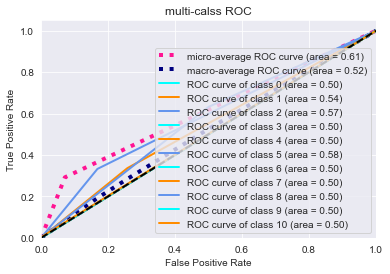

In [241]:
ROC(y_one_hot, y_one_hot_pred_NB)

In [242]:
mnb = MultinomialNB().fit(Xtrain_NB, Ytrain)
y_pred_NB = mnb.predict(Xtest_NB)
accuracy_score(Ytest, y_pred_NB) * 100

29.192312523552317

In [243]:
y_one_hot = label_binarize(Ytest, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y_one_hot_pred_NB = label_binarize(y_pred_NB, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y_one_hot

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [244]:
accuracy_score_array = np.ndarray(shape=(1, 11), dtype=float)
for i in range(11):
    accuracy_score_array[0, i] = accuracy_score(y_one_hot[:, i], y_one_hot_pred_NB[:, i])
accuracy_score_array.mean() * 100

87.12587500428222

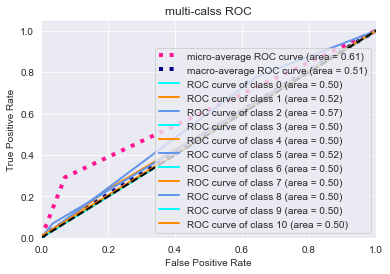

In [245]:
ROC(y_one_hot, y_one_hot_pred_NB)

## Error Based Learning

### Gradient Boost

In [246]:
from sklearn.ensemble import GradientBoostingClassifier

GB = GradientBoostingClassifier(random_state=10)

GB.fit(Xtrain, Ytrain)
y_pred_GB = GB.predict(Xtest)
accuracy_score(Ytest, y_pred_GB) * 100

41.279361889209895

In [247]:
print(classification_report(Ytest, y_pred_GB))

              precision    recall  f1-score   support

           1       0.43      0.12      0.18      4805
           2       0.41      0.50      0.45     15569
           3       0.42      0.65      0.51     17460
           4       0.41      0.18      0.25     11083
           5       0.00      0.00      0.00      2321
           6       0.38      0.54      0.45      6944
           7       0.00      0.00      0.00       545
           8       0.22      0.01      0.01      2073
           9       0.34      0.18      0.24      1010
          10       0.23      0.01      0.02       562
          11       0.49      0.40      0.44      1316

    accuracy                           0.41     63688
   macro avg       0.30      0.24      0.23     63688
weighted avg       0.39      0.41      0.37     63688



In [251]:
y_one_hot = label_binarize(Ytest, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y_one_hot_pred_GB = label_binarize(y_pred_GB, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y_one_hot

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [252]:
accuracy_score_array = np.ndarray(shape=(1, 11), dtype=float)
for i in range(11):
    accuracy_score_array[0, i] = accuracy_score(y_one_hot[:, i], y_one_hot_pred_GB[:, i])
accuracy_score_array.mean() * 100

89.32352034349272

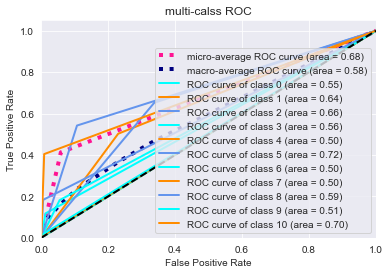

In [253]:
ROC(y_one_hot, y_one_hot_pred_GB)

## CATBoost

In [256]:
CB = CatBoostClassifier(random_state=10, use_best_model=True, iterations=1000)
CB.fit(Xtrain, Ytrain, use_best_model=True, verbose=100, eval_set=(Xtest, Ytest))
y_pred_CB = CB.predict(Xtest)
accuracy_score(Ytest, y_pred_CB) * 100

Learning rate set to 0.120629
0:	learn: 2.2019885	test: 2.2024080	best: 2.2024080 (0)	total: 358ms	remaining: 5m 57s
100:	learn: 1.5154227	test: 1.5307567	best: 1.5307567 (100)	total: 29.9s	remaining: 4m 26s
200:	learn: 1.4849639	test: 1.5121627	best: 1.5121627 (200)	total: 44.7s	remaining: 2m 57s
300:	learn: 1.4682410	test: 1.5067006	best: 1.5067006 (300)	total: 59.3s	remaining: 2m 17s
400:	learn: 1.4540269	test: 1.5047089	best: 1.5047089 (400)	total: 1m 13s	remaining: 1m 50s
500:	learn: 1.4408292	test: 1.5030813	best: 1.5030468 (494)	total: 1m 28s	remaining: 1m 28s
600:	learn: 1.4292575	test: 1.5020822	best: 1.5020822 (600)	total: 1m 42s	remaining: 1m 8s
700:	learn: 1.4179585	test: 1.5015528	best: 1.5015476 (667)	total: 2m 3s	remaining: 52.6s
800:	learn: 1.4064667	test: 1.5016412	best: 1.5014847 (726)	total: 2m 21s	remaining: 35.2s
900:	learn: 1.3961558	test: 1.5019233	best: 1.5014847 (726)	total: 2m 38s	remaining: 17.4s
999:	learn: 1.3862644	test: 1.5021230	best: 1.5014847 (726)	tot

42.44912699409622

In [257]:
print(classification_report(Ytest, y_pred_CB))

              precision    recall  f1-score   support

           1       0.40      0.17      0.24      4805
           2       0.43      0.50      0.46     15569
           3       0.43      0.66      0.52     17460
           4       0.42      0.24      0.30     11083
           5       0.24      0.00      0.01      2321
           6       0.40      0.49      0.44      6944
           7       0.00      0.00      0.00       545
           8       0.36      0.03      0.05      2073
           9       0.39      0.22      0.28      1010
          10       0.44      0.01      0.03       562
          11       0.54      0.43      0.48      1316

    accuracy                           0.42     63688
   macro avg       0.37      0.25      0.25     63688
weighted avg       0.41      0.42      0.39     63688



In [258]:
y_one_hot = label_binarize(Ytest, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y_one_hot_pred_CB = label_binarize(y_pred_CB, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
y_one_hot

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [259]:
accuracy_score_array = np.ndarray(shape=(1, 11), dtype=float)
for i in range(11):
    accuracy_score_array[0, i] = accuracy_score(y_one_hot[:, i], y_one_hot_pred_CB[:, i])
accuracy_score_array.mean() * 100

89.53620490801751

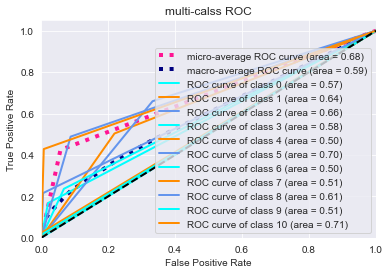

In [260]:
ROC(y_one_hot, y_one_hot_pred_CB)

In [ ]:
### Logistic Regression
# from mlxtend.classifier import LogisticRegression as LR
# from sklearn.metrics import accuracy_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
#
# paramGrid = dict(
#     penalty=['l1', 'l2'],
#     C=[0.1, 1, 10, 100, 1000])
# lrModel = LogisticRegression(random_state=10)
# grid = GridSearchCV(lrModel, paramGrid, cv=3, return_train_score=True)
# grid.fit(Xtrain, Ytrain)
# print(grid.best_params_)
# LR = LogisticRegression(fit_intercept=True, C=10, penalty="l2")
#
# LR.fit(Xtrain, Ytrain)
#
# y_pred_LR = LR.predict(Xtest)
# accuracy_score(Ytest, y_pred_LR) * 100
# print(classification_report(Ytest, y_pred_LR))
# from sklearn import metrics
#
# fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_LR, pos_label=11)
# auc = metrics.auc(fpr, tpr)
# auc
# import matplotlib.pyplot as plt
#
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()
## Gradient boost